In [1]:
import numpy as np
import pandas as pd
from scipy import stats

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

## 🔹 [Two-Way ANOVA 실전 문제]

### 📝 문제:

한 교육기관은 **학습 방법(A/B)**과 **성별(남/여)**이  
학생들의 **시험 성적에 미치는 영향**을 분석하고자 한다.

총 24명의 학생을 학습 방법 × 성별로 나누어  
시험 성적을 다음과 같이 측정하였다:

| 성별 | 학습법 | 점수 |
|------|--------|------|
| 남성 | A      | 85, 88, 86, 87 |
| 남성 | B      | 78, 75, 77, 79 |
| 여성 | A      | 90, 92, 91, 89 |
| 여성 | B      | 82, 83, 84, 81 |

In [3]:
male_A = [85, 88, 86, 87]
male_B = [78, 75, 77, 79]
female_A = [90, 92, 91, 89]
female_B = [82, 83, 84, 81]

data = {
    'score': male_A + male_B + female_A + female_B,
    'gender': ['male'] * 4 + ['male'] * 4 + ['female'] * 4 + ['female'] * 4,
    'method': ['A'] * 4 + ['B'] * 4 + ['A'] * 4 + ['B'] * 4
}

df = pd.DataFrame(data)
df

,score,gender,method
0,85,male,A
1,88,male,A
2,86,male,A
3,87,male,A
4,78,male,B
5,75,male,B
6,77,male,B
7,79,male,B
8,90,female,A
9,92,female,A


In [4]:
H_A = {
    'H0': '성별과 성적이 관계가 없다.',
    'H1': '성별과 성적이 관계가 있다.'
}
H_B = {
    'H0': '학습법과 성적이 관계가 없다.',
    'H1': '학습법과 성적이 관계가 있다.'
}
H_C = {
    'H0': '성별과 학습법이 관계가 없다.',
    'H1': '성별과 학습법이 관계가 있다.'
}

In [5]:
formula = 'score ~ C(gender)*C(method)'
model = ols(formula=formula, data=df).fit()

In [6]:
# ✅ 1. 정규성 검정 (잔차 기준)
print("\n🔹 정규성 검정 (Shapiro-Wilk)")
residuals = model.resid
stat, p = stats.shapiro(residuals)
print(f"p-value: {p:.4f}")
if p > 0.05:
    print("→ 정규성 만족")
else:
    print("→ 정규성 위반")


🔹 정규성 검정 (Shapiro-Wilk)
p-value: 0.2538
→ 정규성 만족


In [7]:
# ✅ 2. 등분산성 검정 (Levene)
print("\n🔹 등분산성 검정 (Levene)")

g1 = df[(df['gender'] == 'male') & (df['method'] == 'A')]['score']
g2 = df[(df['gender'] == 'male') & (df['method'] == 'B')]['score']
g3 = df[(df['gender'] == 'female') & (df['method'] == 'A')]['score']
g4 = df[(df['gender'] == 'female') & (df['method'] == 'B')]['score']

stat, p = stats.levene(g1, g2, g3, g4)
print(f"p-value: {p:.4f}")
if p > 0.05:
    print("→ 등분산성 만족")
else:
    print("→ 등분산성 위반")


🔹 등분산성 검정 (Levene)
p-value: 0.9401
→ 등분산성 만족


In [8]:
anova_result = anova_lm(model, typ=2)
anova_result

,sum_sq,df,F,PR(>F)
C(gender),85.5625,1.0,43.231579,2.631453e-05
C(method),297.5625,1.0,150.347368,3.801510e-08
C(gender):C(method),1.5625,1.0,0.789474,3.917220e-01
Residual,23.7500,12.0,NaN,NaN


In [9]:
if anova_result.loc['C(gender)', 'PR(>F)'] < 0.05:
    print(H_A['H1'])
else:
    print(H_A['H0'])

if anova_result.loc['C(method)', 'PR(>F)'] < 0.05:
    print(H_B['H1'])
else:
    print(H_B['H0'])

if anova_result.loc['C(gender):C(method)', 'PR(>F)'] < 0.05:
    print(H_C['H1'])
else:
    print(H_C['H0'])

성별과 성적이 관계가 있다.
학습법과 성적이 관계가 있다.
성별과 학습법이 관계가 없다.


   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2  meandiff p-adj  lower    upper   reject
---------------------------------------------------------
female_A female_B     -8.0   0.0 -10.9534  -5.0466   True
female_A   male_A     -4.0 0.008  -6.9534  -1.0466   True
female_A   male_B   -13.25   0.0 -16.2034 -10.2966   True
female_B   male_A      4.0 0.008   1.0466   6.9534   True
female_B   male_B    -5.25 0.001  -8.2034  -2.2966   True
  male_A   male_B    -9.25   0.0 -12.2034  -6.2966   True
---------------------------------------------------------


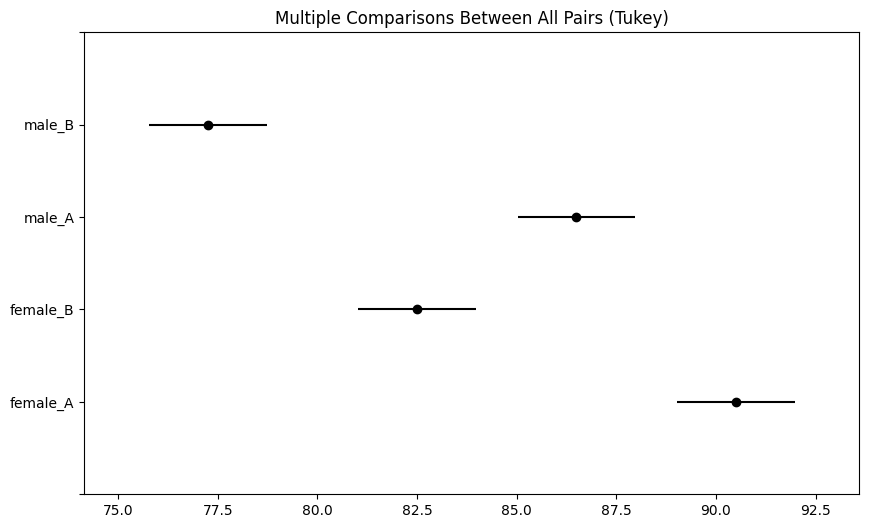

In [10]:
# 사후검정

from statsmodels.stats.multicomp import pairwise_tukeyhsd
df['group'] = df['gender'] + '_' + df['method']

tukey = pairwise_tukeyhsd(endog=df['score'], groups=df['group'], alpha=0.05)
print(tukey.summary())
fig = tukey.plot_simultaneous()

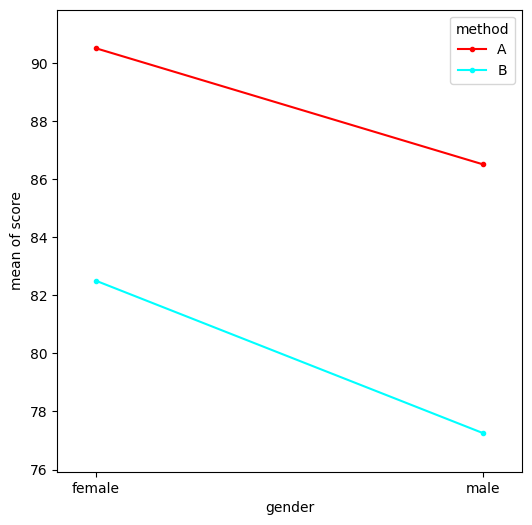

In [13]:
# 사후검정
from statsmodels.graphics.factorplots import interaction_plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6, 6))
fig = interaction_plot(df['gender'], df['method'], df['score'], ax=ax)